# Notebook: calculation of cost and efficiency of rides/rentals campaigns

## Import libraries

In [1]:
import ast
import pandas as pd
import numpy as np
import utils
import os
import getpass
from datetime import date
import datetime 
import json
import time
import sys
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('fivethirtyeight')
%load_ext autoreload
%autoreload 2

username = getpass.getuser()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [2]:
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 60%; }
    div#maintoolbar-container { width: 70%; }
    div.output_scroll { height: 60em; }
</style>
"""))

In [3]:
from IPython.core.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide();
    } else {
        $('div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code view"></form>''')

In [4]:
data_path = 'data'

if not os.path.exists(data_path):
    os.makedirs(data_path)

## Helpers

In [5]:
def query_short(q):
    conn = pyodbc.connect('DSN=Redshift_live')
    df = pd.read_sql(q, conn)
    conn.close()
    return df

windows_connection_name = 'DSN=Redshift_live'

import platform
import json
import datetime

def query(q):
#     if platform.system() == 'Windows':
#         conn = pyodbc.connect(windows_connection_name)
#     elif platform.system() == 'Darwin':
#         with open(mac_redshift_user_file) as fh:
#             creds = json.loads(fh.read())  
#         conn = ('postgresql+psycopg2://' + \
#             creds['user_name'] + ':' + creds['password'] + '@' + \
#             creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'])
#     else: ##Returns the system/OS name, such as 'Linux', 'Darwin', 'Java', 'Windows'. An empty string is returned if the value cannot be determined.
#         return null
            
    print("query started at: {0}".format(datetime.datetime.now().time()))
    df = pd.read_sql(q, conn, chunksize = None)
    print("query ended at: {0}".format(datetime.datetime.now().time()))    
    conn.close()
    return df


import scipy.stats as st
alpha = 0.95 #significance_level

def ttest_2(a,b):
    return st.ttest_ind(a,b, equal_var=False)

def ci(a, alpha):
    t = st.t.interval(alpha, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    return (t[1] - t[0])/2

def list_to_string(lst):
    s = ",".join(map(str, lst))   
    return s

def string_list_to_string(lst):
    s = "'"+"','".join(map(str, lst))+"'"   
    return s

In [6]:
#calculates efficiency of RH platform
#aggregate, calc efficiency, add p-values

def calculate_efficiency_ridehailing(first_field, treatment_field, control_title):
    
    dft = dfa
    
    fields = [first_field, treatment_field]
    control_name = control_title #name of the control group in groupby_1 array

    #set names for aggregations and calcs
    groupby_treatment = dft[fields[1]].unique()#this feature includes control group, "treatment"
    groupby_2 = dft[fields[0]].unique() #additional groupby field, cohort, country etc


    dfs = pd.DataFrame({
        "user_count":dft.groupby(fields)["user_id"].count(),
        "has_ride_sum":dft.groupby(fields)["has_ride"].sum(),
        "has_ride_avg":dft.groupby(fields)["has_ride"].mean(), 

        "discount_all_avg":dft.groupby(fields)["discount_all_sum"].mean(),
        #"discount_sum":dft.groupby(fields)["discount_sum"].sum(),
        "discount_avg":dft.groupby(fields)["discount_sum"].mean(),

        #"gmv_sum":dft.groupby(fields)["ride_price_sum"].sum(),
        "gmv_avg":dft.groupby(fields)["ride_price_sum"].mean(),

        #"nmv_sum":dft.groupby(fields)["price_sum"].sum(),
        "nmv_avg":dft.groupby(fields)["price_sum"].mean(), 

        "finished_order_sum":dft.groupby(fields)["finished_order_count"].sum(),
        "finished_order_avg":dft.groupby(fields)["finished_order_count"].mean(),

    }).reset_index()

    #add control metrics to df
    dfs_control = dfs[dfs[fields[1]]==control_name][[fields[0],"gmv_avg","has_ride_avg","discount_all_avg", "user_count", "finished_order_avg"]]
    dfs_control = dfs_control.rename(columns = {"gmv_avg":"control_gmv_avg",
                                                "has_ride_avg":"control_has_ride_avg",
                                                "discount_all_avg":"control_discount_all_avg",
                                                "user_count": "control_user_count",
                                                "finished_order_avg": "control_finished_order_avg"
                                               })
    dfs = dfs.merge(dfs_control, how = 'left', on = [fields[0]])

    #calculate efficiency
    dfs["gmv_uplift"]= np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["gmv_avg"]-dfs["control_gmv_avg"])

    dfs["gmv_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                dfs["gmv_uplift"]/dfs["discount_all_avg"])

    dfs["activation_uplift"] = np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["has_ride_avg"]-dfs["control_has_ride_avg"])

    dfs["activation_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                dfs["activation_uplift"]/dfs["discount_all_avg"])
    

    dfs["incremental_riders"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                dfs["activation_uplift"]*dfs["user_count"])
    
    dfs["incremental_rides"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                (dfs["finished_order_avg"]-dfs["control_finished_order_avg"])*dfs["finished_order_sum"])

    #merge testgroup names
    #dfs = pd.merge(dfs, testgroups, how = "left", left_on = "treatment", right_on= "treatment_name")

    #p-value for AB
    #fields in user level dataset
    fields_p = ["discount_all_sum","ride_price_sum","price_sum","finished_order_count","has_ride"]


    for group in groupby_2:
        for treatment in groupby_treatment: 
            for field in fields_p:
                p=ttest_2(dft[(dft[fields[1]]==control_name)&(dft[fields[0]] == group)][field],
                          dft[(dft[fields[1]]==treatment)&(dft[fields[0]] == group)][field])[1]
                p = round(p,4)
                #rename some fields
                if field == "ride_price_sum": field = "gmv_sum"
                if field == "price_sum": field = "nmv_sum"
                #print(country + ' ' + treatment + ' ' + field + ' {}'.format(p))
                dfs.loc[(dfs[fields[1]]==treatment)&(dfs[fields[0]]==group), str(field) + ' p-val'] = p
    
    return dfs

In [7]:
#efficiency for RENTALS
#aggregate, calc efficiency, add p-values

def calculate_efficiency_rentals(first_field, treatment_field, control_title):
    
    dft = dfa
    
    fields = [first_field, treatment_field]
    control_name = control_title #name of the control group in groupby_1 array

    #set names for aggregations and calcs
    groupby_treatment = dft[fields[1]].unique()#this feature includes control group, "treatment"
    groupby_2 = dft[fields[0]].unique() #additional groupby field, cohort, country etc


    dfs = pd.DataFrame({
        "user_count":dft.groupby(fields)["user_id"].count(),
        "has_ride_sum":dft.groupby(fields)["r_has_ride"].sum(),
        "has_ride_avg":dft.groupby(fields)["r_has_ride"].mean(), 

        "discount_all_avg":dft.groupby(fields)["r_discount_all_sum"].mean(),
        #"discount_sum":dft.groupby(fields)["discount_sum"].sum(),
        "discount_avg":dft.groupby(fields)["r_discount_sum"].mean(),

        #"gmv_sum":dft.groupby(fields)["ride_price_sum"].sum(),
        "gmv_avg":dft.groupby(fields)["r_ride_price_sum"].mean(),

        #"nmv_sum":dft.groupby(fields)["price_sum"].sum(),
        "nmv_avg":dft.groupby(fields)["r_price_sum"].mean(), 

        "finished_order_sum":dft.groupby(fields)["r_finished_order_count"].sum(),
        "finished_order_avg":dft.groupby(fields)["r_finished_order_count"].mean()

    }).reset_index()

    #add control metrics to df
    dfs_control = dfs[dfs[fields[1]]==control_name][[fields[0],"gmv_avg","has_ride_avg","discount_all_avg", "user_count", "finished_order_avg"]]
    dfs_control = dfs_control.rename(columns = {"gmv_avg":"control_gmv_avg",
                                                "has_ride_avg":"control_has_ride_avg",
                                                "discount_all_avg":"control_discount_all_avg",
                                                "user_count": "control_user_count",
                                                "finished_order_avg": "control_finished_order_avg"
                                               })
    dfs = dfs.merge(dfs_control, how = 'left', on = [fields[0]])

    #calculate efficiency
    dfs["gmv_uplift"]= np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["gmv_avg"]-dfs["control_gmv_avg"])

    dfs["gmv_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                dfs["gmv_uplift"]/dfs["discount_all_avg"])

    dfs["activation_uplift"] = np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["has_ride_avg"]-dfs["control_has_ride_avg"])

    dfs["activation_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                dfs["activation_uplift"]/dfs["discount_all_avg"])

    dfs["incremental_riders"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                dfs["activation_uplift"]*dfs["user_count"])

    dfs["incremental_rides"]=np.where(dfs[fields[1]]==control_name,
                                np.nan,
                                (dfs["finished_order_avg"]-dfs["control_finished_order_avg"])*dfs["finished_order_sum"])

    #merge testgroup names
    #dfs = pd.merge(dfs, testgroups, how = "left", left_on = "treatment", right_on= "treatment_name")

    #p-value for AB
    #fields in user level dataset
    fields_p = ["discount_all_sum","ride_price_sum","price_sum","finished_order_count","has_ride"]


    for group in groupby_2:
        for treatment in groupby_treatment: 
            for field in fields_p:
                p=ttest_2(dft[(dft[fields[1]]==control_name)&(dft[fields[0]] == group)][field],
                          dft[(dft[fields[1]]==treatment)&(dft[fields[0]] == group)][field])[1]
                p = round(p,4)
                #rename some fields
                if field == "ride_price_sum": field = "gmv_sum"
                if field == "price_sum": field = "nmv_sum"
                #print(country + ' ' + treatment + ' ' + field + ' {}'.format(p))
                dfs.loc[(dfs[fields[1]]==treatment)&(dfs[fields[0]]==group), str(field) + ' p-val'] = p
    
    return dfs

## SQL query to get tests and activity of rides on rentals and RH

In [8]:
sql = """

with s as (
	select 
    '{0}'::date as dt_start, --campaign start day
	'{1}'::date as dt_end, --campaign end day
	'{2}' as city
)
,
cities as (
	select 
		id,
		country_code
	from admin_system_city c 
	where name = (select city from s)
)
,
rfm as (
    select 
        week,
        user_id,
        city_id,
        cohort
        from etl_united_rider_cohorts_max_weekly_by_city
        where city_id = (select id from cities) and week = (select dt_start-1 from s)
)
,
users as (
SELECT 
	t.id as test_id,
	t.name as test_name,
	e.user_id,
	e.created AS enrollment_created,
	case when tr.bonus_type = 'targeted_control_campaign' THEN 'control' ELSE 'treatment' END AS treatment_type,
	case when tr.bonus_type = 'targeted_control_campaign' THEN 1 ELSE 0 END AS is_control,
	json_extract_path_text(tr.bonus_data,'targeted_campaign_id') targeted_campaign_id_str,
	case when targeted_campaign_id_str ='' then null else targeted_campaign_id_str::int end as targeted_campaign_id,
    c.name as campaign_name,
	json_extract_path_text(c.bonus_data,'percentage') campaign_percentage,
	json_extract_path_text(c.bonus_data,'max_value') campaign_max_value
FROM public.campaign_targeting_test t 
left join public.campaign_targeting_treatment tr on tr.test_id = t.id
LEFT JOIN public.campaign_targeting_enrollment e on e.treatment_id = tr.id
left join campaign_targeted_campaign c on c.id = case when json_extract_path_text(tr.bonus_data,'targeted_campaign_id') ='' then null else json_extract_path_text(tr.bonus_data,'targeted_campaign_id')::int end
where 
	date_trunc('week',t.created)::date = (select date_trunc('week',dt_start)::date from s)
	AND e.state = 'finished' --enrollments without error
	AND e.no = 1 --get only the first enrollment
	
    AND t.city_id = (select id from cities)
)
,
orders as (
	SELECT DISTINCT
		company_order_search_filter__filter_search_category_id AS category,
		company_order__id AS order_id,
		company_order_try__driver_id AS driver_id,
		company_order__user_id AS user_id,
		company_order__country country,
		
		company_order__state AS o_state,
		company_order__created o_created,
		
		company_order_try__id as ot_id,
		company_order_try__state AS ot_state,
		company_order_try__created ot_created,
			
		COALESCE(company_order_try__ride_price/cr.rate,0) ride_price,
		COALESCE(company_order_try__price/cr.rate,0) price,
		ride_price - (case when tcc.order_try_id is null then ride_price else price end) as discount, --discount from signup campaigns under analysis
		ride_price - price as discount_all, --all discounts, including GGs, other campaigns, compensations etc
		
		company_order_try__retry_to_try
	
	FROM etl_search_denormalized_view v
	INNER JOIN users u ON u.user_id = v.company_order__user_id --select only users in the sample
	LEFT JOIN vw_currency_exchange_rates cr ON 
	            (company_order_try__price_currency = cr.currency) 
	            AND DATE(cr.valid_on) = DATE(company_order_try__created)
	LEFT JOIN (select * from campaign_targeted_campaign_code_usage tcc where tcc.domain = 'ridehailing' and tcc.targeted_campaign_id IN (select distinct t.targeted_campaign_id from users t where t.targeted_campaign_id is not null)
				) tcc on 
	    			tcc.order_try_id = v.company_order_try__id 
	    			AND tcc.user_id = v.company_order__user_id
	WHERE 
		v.company_order_try__created::date >= (SELECT dt_start FROM s) --global monitoring period 
		AND v.company_order_try__created::date <= (SELECT dt_end FROM s) --global monitoring period, max from camapign or holdout end
		AND v.company_order__city_id in (SELECT id FROM cities)
		AND v.company_order__country in (SELECT country_code FROM cities)
		AND company_order_try__state = 'finished'
		AND v.company_order__state = 'finished'
		AND company_order_try__retry_to_try is null
		AND not nvl(duplicate_order, false) 
)
,
rental_orders as(
    SELECT DISTINCT 
        r_order.id, 
        r_order.user_id, 
        r_order.city_id, 
        
        r_order.state, 
        r_order.created,
        
        COALESCE(r_order.price/cr.rate,0) as ride_price,
        COALESCE(r_order.final_price/cr.rate,0) as price,
        case when tcc.order_try_id is null then 0 else COALESCE(tcc.value/cr.rate,0) end as discount, 
        COALESCE(r_order.discount/cr.rate,0) as discount_all
    
    
    FROM rental.rental_order_order r_order
    INNER JOIN users u ON u.user_id = r_order.user_id --select only users in the sample
    LEFT JOIN vw_currency_exchange_rates cr ON 
	            (r_order.currency = cr.currency)
                AND DATE(cr.valid_on) = DATE(r_order.created)
    LEFT JOIN (select * from campaign_targeted_campaign_code_usage tcc where tcc.domain = 'rental' and tcc.targeted_campaign_id IN (select distinct t.targeted_campaign_id from users t where t.targeted_campaign_id is not null)
				) tcc on 
	    			tcc.order_try_id = r_order.id 
	    			AND tcc.user_id = r_order.user_id
        
    WHERE 
        r_order.created::date >= (SELECT dt_start FROM S)
        AND r_order.created::date <= (SELECT dt_end FROM S)
        AND r_order.city_id in (SELECT id FROM cities)
        AND r_order.country in (SELECT country_code FROM cities)
        AND r_order.state = 'finished'
        
),
orders_agg AS (
	SELECT 
		o.user_id, 
		min(o.ot_created) as first_order_created, 
		count(o.order_id) as finished_order_count,
		sum(o.ride_price) ride_price,
		sum(o.price) price,
		sum(o.discount) discount,
		sum(o.discount_all) discount_all
	FROM orders o 
	group by o.user_id
)
,
rental_orders_agg AS(
    	SELECT 
		ro.user_id, 
		min(ro.created) as first_order_created, 
		count(ro.id) as finished_order_count,
		sum(ro.ride_price) ride_price,
		sum(ro.price) price,
		sum(ro.discount) discount,
		sum(ro.discount_all) discount_all
	FROM rental_orders ro
	group by ro.user_id

)
,
users_activity AS (
	SELECT 
	
		--user details
		u.user_id,
        rfm.cohort,
		u.test_id,
		u.test_name,
        u.campaign_name,
		u.treatment_type,
		u.is_control,
		u.targeted_campaign_id,
		u.campaign_percentage,
		u.campaign_max_value,
	
		--order aggregations from ridehailing
		coalesce(od.finished_order_count,0) finished_order_count,
		coalesce(od.ride_price,0) ride_price_sum,
		coalesce(od.price,0) price_sum,
		coalesce(od.discount,0) discount_sum,
		coalesce(od.discount_all,0) discount_all_sum,
		case when coalesce(od.finished_order_count,0)>0 then 1 else 0 end as has_ride,
        
        --order aggregations from rentals
        coalesce(rod.finished_order_count,0) r_finished_order_count,
		coalesce(rod.ride_price,0) r_ride_price_sum,
		coalesce(rod.price,0) r_price_sum,
		coalesce(rod.discount,0) r_discount_sum,
		coalesce(rod.discount_all,0) r_discount_all_sum,
		case when coalesce(rod.finished_order_count,0)>0 then 1 else 0 end as r_has_ride
        

	FROM users u
	left join orders_agg od on od.user_id = u.user_id
    left join rental_orders_agg rod on rod.user_id = u.user_id
    left join rfm on rfm.user_id = u.user_id
)
select 
    *
from users_activity 
order by user_id

"""

In [9]:
sql_cost = """

with s as (
	select 
    '{0}'::date as dt_start, --campaign start day
	'{1}'::date as dt_end, --campaign end day
	'{2}' as city
)
,
cities as (
	select 
		id,
		country_code
	from admin_system_city c 
	where name = (select city from s)
)
,
gmv_rides as (
SELECT
    COALESCE(SUM(company_order_try.ride_price   /  currency_exchange_rates.rate ), 0) AS rides_gmv_eur,
    COALESCE(SUM((company_order_try.price) /  currency_exchange_rates.rate ), 0) AS rides_price_eur,
    COUNT (DISTINCT company_order.user_id) as rides_unique_riders, 
    COUNT (company_order.id) as rides_finished_rides,    
    rides_gmv_eur - rides_price_eur as total_discount_eur
FROM public.company_order  AS company_order
LEFT JOIN public.company_order_try  AS company_order_try ON company_order.id = company_order_try.order_id
      AND company_order.city_id=company_order_try.city_id
      AND company_order.created <= company_order_try.created

LEFT JOIN public.vw_currency_exchange_rates  AS currency_exchange_rates ON company_order_try.price_currency = currency_exchange_rates.currency
      AND (DATE(company_order_try.created )) = (DATE(currency_exchange_rates.valid_on ))
WHERE (company_order.company_id ) IS NULL AND (company_order.reseller_company_id ) IS NULL AND (company_order_try.retry_to_try ) IS NULL AND (company_order_try.created >= (select dt_start from s) AND company_order_try.created <= (select dt_end from s)) AND company_order_try.city_id = (SELECT id from cities) AND company_order_try.state = 'finished'
)
,
gmv_rentals as (
SELECT 
    COALESCE(SUM(roo.price   /  cr.rate ), 0) AS rentals_gmv_eur,
    COALESCE(SUM(roo.final_price /  cr.rate ), 0) AS rentals_price_eur,
    COUNT (DISTINCT roo.user_id) as rentals_unique_riders, 
    COUNT (roo.id) as rentals_finished_rides,
    rentals_gmv_eur - rentals_price_eur as total_discount_eur
FROM rental.rental_order_order roo 
LEFT JOIN public.vw_currency_exchange_rates cr ON 
	            (roo.currency = cr.currency) 
	            AND DATE(cr.valid_on) = DATE(roo.created) 
WHERE roo.state = 'finished' AND roo.city_id = (SELECT id from cities) AND (roo.created >= (select dt_start from s) AND roo.created <= (select dt_end from s)) 
)
,
campaigns as (
SELECT id
FROM campaign_targeted_campaign c
WHERE date_trunc('week',c.created)::date = (select date_trunc('week',dt_start)::date from s) and c.state = 'approved' and c.city_id = (select id from cities)
)
SELECT 
c.name, 
c.start,
c.end, 
c.bonus_data,
tcc.domain,
CASE WHEN tcc.domain = 'rental' THEN COALESCE(SUM(tcc.value/cr.rate),0) ELSE NULL END AS rental_cost_eur, 
CASE WHEN tcc.domain = 'ridehailing' THEN COALESCE(SUM(tcc.value/cr.rate),0) ELSE NULL END AS rides_cost_eur, 
CASE WHEN tcc.domain = 'rental' THEN COUNT(tcc.id) ELSE NULL END AS rental_discounted_rides, 
CASE WHEN tcc.domain = 'ridehailing' THEN COUNT(tcc.id) ELSE NULL END AS rides_discounted_rides, 
(SELECT rentals_gmv_eur FROM gmv_rentals) as rental_gmv_eur, 
(SELECT rides_gmv_eur FROM gmv_rides) as rides_gmv_eur, 
(SELECT rentals_unique_riders FROM gmv_rentals) as rental_unique_riders, 
(SELECT rides_unique_riders FROM gmv_rides) as rides_unique_riders, 
(SELECT rentals_finished_rides FROM gmv_rentals) as rental_finished_rides, 
(SELECT rides_finished_rides FROM gmv_rides) as rides_finished_rides, 
COALESCE(rental_cost_eur/rental_gmv_eur, 0)*100 as rental_cost_pct,
COALESCE(rides_cost_eur/rides_gmv_eur, 0)*100 as rides_cost_pct


FROM campaign_targeted_campaign_code_usage tcc
LEFT JOIN campaign_targeted_campaign c on c.id = tcc.targeted_campaign_id
LEFT JOIN public.vw_currency_exchange_rates cr ON 
	            (tcc.currency = cr.currency) 
	            AND DATE(cr.valid_on) = DATE(tcc.created) 
WHERE c.id in (select id from campaigns) 
GROUP BY 1,2,3,4,5
"""

## YOUR INPUTS

In [10]:
campaign_start = '2021-05-04'
campaign_end = '2021-05-11'
city = 'Stockholm'
country = 'Sweden'

In [11]:
# from IPython.display import display, Markdown, Latex
print("Fetching the results of tests in {} from {} to {}".format(city, campaign_start, campaign_end))

Fetching the results of tests in Stockholm from 2021-05-04 to 2021-05-11


## Costs and stats

In [12]:
costs = utils.read_from_redshift(sql_cost.format(campaign_start, campaign_end, city))

query started at: 20:26:37.757978
query ended at: 20:26:45.097821


In [39]:
costs['rides_rides_share_pct'] = costs['rides_discounted_rides']/costs['rides_finished_rides']*100
costs['rental_rides_share_pct'] = costs['rental_discounted_rides']/costs['rental_finished_rides']*100

### Ridehailing costs

In [41]:
costs[costs['domain'] == 'ridehailing'][['name', 'start', 'end', 'bonus_data', 'rides_cost_eur', 'rides_discounted_rides', 'rides_gmv_eur','rides_unique_riders', 'rides_finished_rides', 'rides_cost_pct', 'rides_rides_share_pct']]

,name,start,end,bonus_data,rides_cost_eur,rides_discounted_rides,rides_gmv_eur,rides_unique_riders,rides_finished_rides,rides_cost_pct,rides_rides_share_pct
1,"SE, Stockholm, 2021W18-W19, morning time test,...",2021-05-03 22:00:00,2021-05-17 21:59:59,"{""percentage"":40,""max_value"":60}",5930.013,1172.000,1556658.559,52593,94217,0.380,1.244
4,"SE, Stockholm, 2021W18, HF, -25% x 10 (50 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":25,""max_value"":50}",40851.250,11349.000,1556658.559,52593,94217,2.620,12.046
6,"SE, Stockholm, 2021W18-W19, evening time test,...",2021-05-03 22:00:00,2021-05-17 21:59:59,"{""percentage"":40,""max_value"":60}",12031.574,2358.000,1556658.559,52593,94217,0.770,2.503
8,"SE, Stockholm, 2021W18, LA, -60% x 10 (120 SEK) C",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":60,""max_value"":120}",12600.414,1347.000,1556658.559,52593,94217,0.800,1.430
9,"SE, Stockholm, 2021W18, MA, -30% x 10 (60 SEK) C",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":30,""max_value"":60}",6070.457,1355.000,1556658.559,52593,94217,0.380,1.438
10,"SE, Stockholm, 2021W18, LA, -50% x 10 (100 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":50,""max_value"":100}",29794.086,3885.000,1556658.559,52593,94217,1.910,4.123
11,"SE, Stockholm, 2021W18, NA, -60% x 10 (120 SEK) C",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":60,""max_value"":120}",9888.586,1044.000,1556658.559,52593,94217,0.630,1.108
12,"SE, Stockholm, 2021W18, MA, -20% x 10 (40 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":20,""max_value"":40}",11744.444,3950.000,1556658.559,52593,94217,0.750,4.192
13,"SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":50,""max_value"":100}",25445.720,3292.000,1556658.559,52593,94217,1.630,3.494


In [14]:
print('TOTAL COST OF RIDEHAILING CAMPAIGNS: ', round(costs[costs['domain'] == 'ridehailing']['rides_cost_pct'].sum(),2), '%')

TOTAL COST OF RIDEHAILING CAMPAIGNS:  9.87 %


### Rentals costs

In [15]:
costs[costs['domain'] == 'rental'][['name', 'start', 'end', 'bonus_data', 'rental_cost_eur', 'rental_discounted_rides', 'rental_gmv_eur','rental_unique_riders', 'rental_finished_rides', 'rental_cost_pct', 'rental_rides_share_pct']]

,name,start,end,bonus_data,rental_cost_eur,rental_discounted_rides,rental_gmv_eur,rental_unique_riders,rental_finished_rides,rental_cost_pct,rental_rides_share_pct
0,"SE, Stockholm, 2021W18, MA, -30% x 10 (60 SEK) C",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":30,""max_value"":60}",85.182,388.000,30199.964,12486,43182,0.280,0.899
2,"SE, Stockholm, 2021W18, NA, -60% x 10 (120 SEK) C",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":60,""max_value"":120}",793.139,1653.000,30199.964,12486,43182,2.620,3.828
3,"SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":50,""max_value"":100}",1942.525,5261.000,30199.964,12486,43182,6.430,12.183
5,"SE, Stockholm, 2021W18, MA, -20% x 10 (40 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":20,""max_value"":40}",204.890,1388.000,30199.964,12486,43182,0.670,3.214
7,"SE, Stockholm, 2021W18, LA, -50% x 10 (100 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":50,""max_value"":100}",555.212,1411.000,30199.964,12486,43182,1.830,3.268
15,"SE, Stockholm, 2021W18, HF, -25% x 10 (50 SEK) B",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":25,""max_value"":50}",618.021,3357.000,30199.964,12486,43182,2.040,7.774
16,"SE, Stockholm, 2021W18, LA, -60% x 10 (120 SEK) C",2021-05-03 22:00:00,2021-05-10 21:59:59,"{""percentage"":60,""max_value"":120}",184.172,429.000,30199.964,12486,43182,0.600,0.993


In [16]:
print('TOTAL COST OF RENTAL CAMPAIGNS: ', round(costs[costs['domain'] == 'rental']['rental_cost_pct'].sum(),2), '%')

TOTAL COST OF RENTAL CAMPAIGNS:  14.47 %


# Start querying

In [17]:
overwrite_file = False

filename_df_riders = 'test_activity_{}_{}_{}_{}.csv'.format(country, city,campaign_start,campaign_end)

if filename_df_riders not in os.listdir(data_path) or overwrite_file: 
    dfa = utils.read_from_redshift(sql.format(
        campaign_start,
        campaign_end,
        city
    )) 
    dfa.to_csv('{}/{}'.format(data_path,filename_df_riders), compression='gzip', index=False)
else:
    print('reading from file')
    dfa = pd.read_csv('{}/{}'.format(data_path,filename_df_riders), compression = 'gzip')

query started at: 20:26:45.784515
query ended at: 20:29:39.346627


In [30]:
dfa

,user_id,cohort,test_id,test_name,campaign_name,treatment_type,is_control,targeted_campaign_id,campaign_percentage,campaign_max_value,finished_order_count,ride_price_sum,price_sum,discount_sum,discount_all_sum,has_ride,r_finished_order_count,r_ride_price_sum,r_price_sum,r_discount_sum,r_discount_all_sum,r_has_ride
0,5715,high_recency,22973,"SE, Stockholm, 2021W18, Low activity","SE, Stockholm, 2021W18, LA, -50% x 10 (100 SEK) B",treatment,0,32028.000,50,100,0,0.000,0.000,0.000,0.000,0,3,2.975,1.993,0.982,0.982,1
3,11303,high_recency,22972,"SE, Stockholm, 2021W18, Not active","SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",treatment,0,32026.000,50,100,0,0.000,0.000,0.000,0.000,0,5,0.000,0.000,0.000,0.000,1
4,15978,low_activity,22973,"SE, Stockholm, 2021W18, Low activity","SE, Stockholm, 2021W18, LA, -50% x 10 (100 SEK) B",treatment,0,32028.000,50,100,0,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0
8,27312,not_active_last_4_month,22972,"SE, Stockholm, 2021W18, Not active","SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",treatment,0,32026.000,50,100,0,0.000,0.000,0.000,0.000,0,1,1.450,0.725,0.726,0.726,1
10,36120,high_recency,22972,"SE, Stockholm, 2021W18, Not active","SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",treatment,0,32026.000,50,100,0,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842825,70848485,signed_up_less_than_14_days_ago,22972,"SE, Stockholm, 2021W18, Not active","SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",treatment,0,32026.000,50,100,0,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0
842827,70848930,signed_up_less_than_14_days_ago,22972,"SE, Stockholm, 2021W18, Not active","SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",treatment,0,32026.000,50,100,0,0.000,0.000,0.000,0.000,0,1,1.373,0.686,0.686,0.686,1
842829,70848948,signed_up_less_than_14_days_ago,22972,"SE, Stockholm, 2021W18, Not active",None,control,1,nan,None,None,0,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0
842834,70849866,signed_up_less_than_14_days_ago,22972,"SE, Stockholm, 2021W18, Not active","SE, Stockholm, 2021W18, NA, -50% x 10 (100 SEK) B",treatment,0,32026.000,50,100,0,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0


In [31]:
dfa.groupby(['test_name','treatment_type'])[['user_id', 'has_ride', 'r_has_ride']].agg(users_count = ('user_id', 'count'), 
                                                                                                           rides_has_ride = ('has_ride', 'sum'), 
                                                                                                           rental_has_ride = ('r_has_ride', 'sum'))

users_count  \
test_name                               treatment_type                
SE, Stockholm, 2021W18, High Frequency  control               15272   
                                        treatment             22818   
SE, Stockholm, 2021W18, Low activity    control                4310   
                                        treatment             38875   
SE, Stockholm, 2021W18, Medium activity control                1810   
                                        treatment             16589   
SE, Stockholm, 2021W18, Not active      control               25001   
                                        treatment            225095   

                                                        rides_has_ride  \
test_name                               treatment_type                   
SE, Stockholm, 2021W18, High Frequency  control                   3400   
                                        treatment                 6808   
SE, Stockholm, 2021W18, Low activity    control                    242   
                                        treatment                 3700   
SE, Stockholm, 2021W18, Medium activity control                    309   
                                        treatment                 3822   
SE, Stockholm, 2021W18, Not active      control                    214   
                                        treatment                 3099   

                                                        rental_has_ride  
test_name                               treatment_type                   
SE, Stockholm, 2021W18, High Frequency  control                     844  
                                        treatment                  1341  
SE, Stockholm, 2021W18, Low activity    control                      87  
                                        treatment                   778  
SE, Stockholm, 2021W18, Medium activity control                      81  
                                        treatment                   712  
SE, Stockholm, 2021W18, Not active      control                     321  
                                        treatment                  2584

## Calculate efficiency

### There are two functions: 1) calculate_efficiency_ridehailing 2) calculate_efficiency_rentals. 

You need to indicate in those functions --> 
- 1. Variable on which you separate riders (e.g. test_name)
- 2. Variable that indicates treatment or control (e.g. treatment_type)
- 3. Name of control group within your variable from point 2 (e.g. control) 

Example: calculate_efficiency_ridehailing('test_name', 'treatment_type', 'control')

## RIDEHAILING

In [32]:
rh_df = calculate_efficiency_ridehailing('test_name', 'treatment_type', 'control')
rh_df

,test_name,treatment_type,user_count,has_ride_sum,has_ride_avg,discount_all_avg,discount_avg,gmv_avg,nmv_avg,finished_order_sum,finished_order_avg,control_gmv_avg,control_has_ride_avg,control_discount_all_avg,control_user_count,control_finished_order_avg,gmv_uplift,gmv_uplift_ratio,activation_uplift,activation_uplift_ratio,incremental_riders,incremental_rides,discount_all_sum p-val,gmv_sum p-val,nmv_sum p-val,finished_order_count p-val,has_ride p-val
0,"SE, Stockholm, 2021W18, High Frequency",control,15272,3400,0.223,0.076,0.000,5.777,5.701,5461,0.358,5.777,0.223,0.076,15272,0.358,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
1,"SE, Stockholm, 2021W18, High Frequency",treatment,22818,6808,0.298,1.864,1.790,8.809,6.945,12420,0.544,5.777,0.223,0.076,15272,0.358,3.032,1.627,0.076,0.041,1728.037,2319.120,0.000,0.000,0.000,0.000,0.000
2,"SE, Stockholm, 2021W18, Low activity",control,4310,242,0.056,0.057,0.001,1.279,1.222,321,0.074,1.279,0.056,0.057,4310,0.074,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
3,"SE, Stockholm, 2021W18, Low activity",treatment,38875,3700,0.095,1.148,1.094,2.652,1.504,5658,0.146,1.279,0.056,0.057,4310,0.074,1.373,1.196,0.039,0.034,1517.227,402.088,0.000,0.000,0.003,0.000,0.000
4,"SE, Stockholm, 2021W18, Medium activity",control,1810,309,0.171,0.053,0.000,3.953,3.900,437,0.241,3.953,0.171,0.053,1810,0.241,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
5,"SE, Stockholm, 2021W18, Medium activity",treatment,16589,3822,0.230,1.138,1.074,5.875,4.736,5750,0.347,3.953,0.171,0.053,1810,0.241,1.922,1.688,0.060,0.052,989.955,604.778,0.000,0.000,0.003,0.000,0.000
6,"SE, Stockholm, 2021W18, Not active",control,25001,214,0.009,0.014,0.001,0.208,0.194,264,0.011,0.208,0.009,0.014,25001,0.011,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
7,"SE, Stockholm, 2021W18, Not active",treatment,225095,3099,0.014,0.167,0.157,0.399,0.232,4783,0.021,0.208,0.009,0.014,25001,0.011,0.191,1.146,0.005,0.031,1172.264,51.127,0.000,0.000,0.031,0.000,0.000


### Results

<function matplotlib.pyplot.show(*args, **kw)>

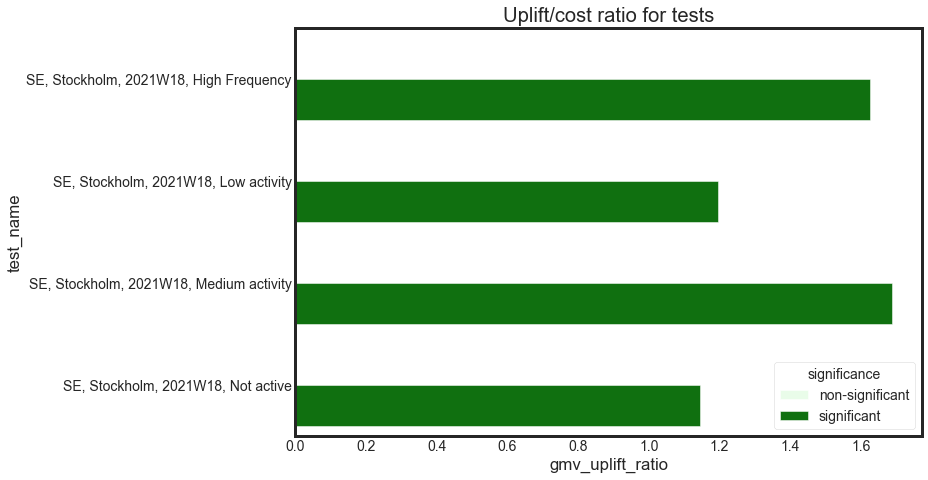

In [33]:
import seaborn as sns
rh_df['significance'] = np.where(rh_df['gmv_sum p-val'] <= 0.05, "significant", 'non-significant' )
plt.figure(figsize=(10,7))
sns.set_style("white")
sns.barplot(y = 'test_name', x = 'gmv_uplift_ratio', hue = 'significance', color = 'green', data = rh_df, orient = "h")
plt.title('Uplift/cost ratio for tests')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

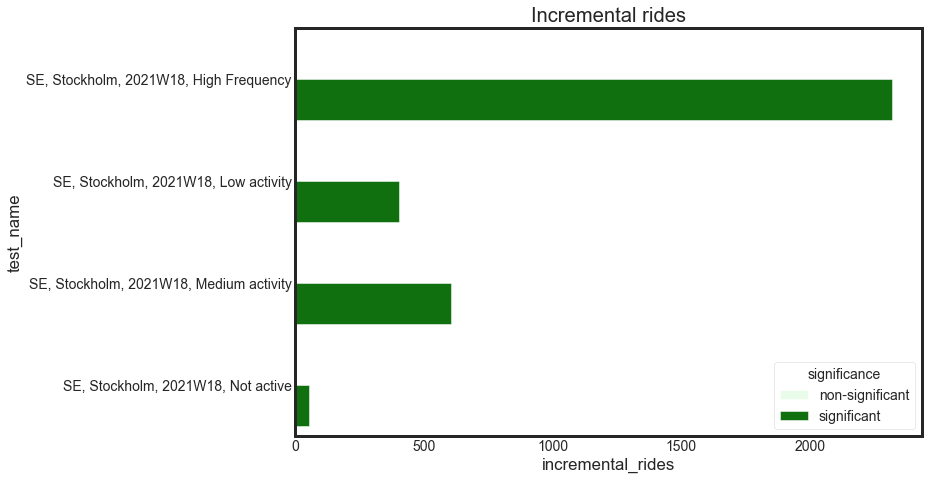

In [34]:
import seaborn as sns
rh_df['significance'] = np.where(rh_df['finished_order_count p-val'] <= 0.05, "significant", 'non-significant' )
plt.figure(figsize=(10,7))
sns.set_style("white")
sns.barplot(y = 'test_name', x = 'incremental_rides', hue = 'significance', color = 'green', data = rh_df, orient = "h")
plt.title('Incremental rides')
plt.show

## RENTALS

In [35]:
rentals_df = calculate_efficiency_rentals('test_name', 'treatment_type', 'control')
rentals_df

,test_name,treatment_type,user_count,has_ride_sum,has_ride_avg,discount_all_avg,discount_avg,gmv_avg,nmv_avg,finished_order_sum,finished_order_avg,control_gmv_avg,control_has_ride_avg,control_discount_all_avg,control_user_count,control_finished_order_avg,gmv_uplift,gmv_uplift_ratio,activation_uplift,activation_uplift_ratio,incremental_riders,incremental_rides,discount_all_sum p-val,gmv_sum p-val,nmv_sum p-val,finished_order_count p-val,has_ride p-val
0,"SE, Stockholm, 2021W18, High Frequency",control,15272,844,0.055,0.000,0.000,0.144,0.144,2791,0.183,0.144,0.055,0.000,15272,0.183,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
1,"SE, Stockholm, 2021W18, High Frequency",treatment,22818,1341,0.059,0.027,0.027,0.153,0.126,4722,0.207,0.144,0.055,0.000,15272,0.183,0.009,0.319,0.004,0.130,79.974,114.221,0.000,0.000,0.000,0.000,0.000
2,"SE, Stockholm, 2021W18, Low activity",control,4310,87,0.020,0.000,0.000,0.048,0.048,287,0.067,0.048,0.020,0.000,4310,0.067,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
3,"SE, Stockholm, 2021W18, Low activity",treatment,38875,778,0.020,0.019,0.019,0.052,0.033,2730,0.070,0.048,0.020,0.000,4310,0.067,0.004,0.214,-0.000,-0.009,-6.716,9.926,0.000,0.000,0.003,0.000,0.000
4,"SE, Stockholm, 2021W18, Medium activity",control,1810,81,0.045,0.000,0.000,0.115,0.115,275,0.152,0.115,0.045,0.000,1810,0.152,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
5,"SE, Stockholm, 2021W18, Medium activity",treatment,16589,712,0.043,0.017,0.017,0.107,0.089,2420,0.146,0.115,0.045,0.000,1810,0.152,-0.008,-0.463,-0.002,-0.105,-30.381,-14.650,0.000,0.000,0.003,0.000,0.000
6,"SE, Stockholm, 2021W18, Not active",control,25001,321,0.013,0.000,0.000,0.034,0.034,1324,0.053,0.034,0.013,0.000,25001,0.053,nan,nan,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
7,"SE, Stockholm, 2021W18, Not active",treatment,225095,2584,0.011,0.012,0.012,0.033,0.021,11705,0.052,0.034,0.013,0.000,25001,0.053,-0.001,-0.052,-0.001,-0.112,-306.104,-11.209,0.000,0.000,0.031,0.000,0.000


<function matplotlib.pyplot.show(*args, **kw)>

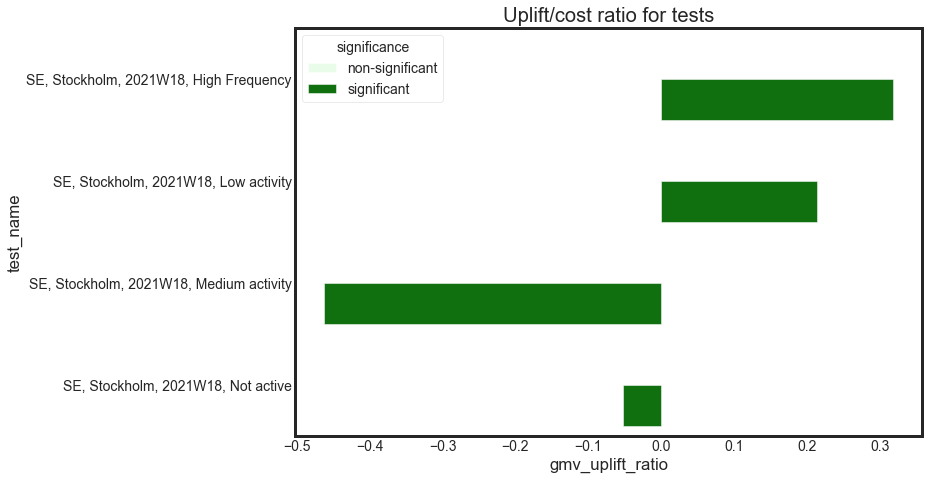

In [36]:
import seaborn as sns
rentals_df['significance'] = np.where(rentals_df['gmv_sum p-val'] <= 0.05, "significant", 'non-significant' )
plt.figure(figsize=(10,7))
sns.set_style("white")
sns.barplot(y = 'test_name', x = 'gmv_uplift_ratio', hue = 'significance', color = 'green', data = rentals_df, orient = "h")
plt.title('Uplift/cost ratio for tests')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

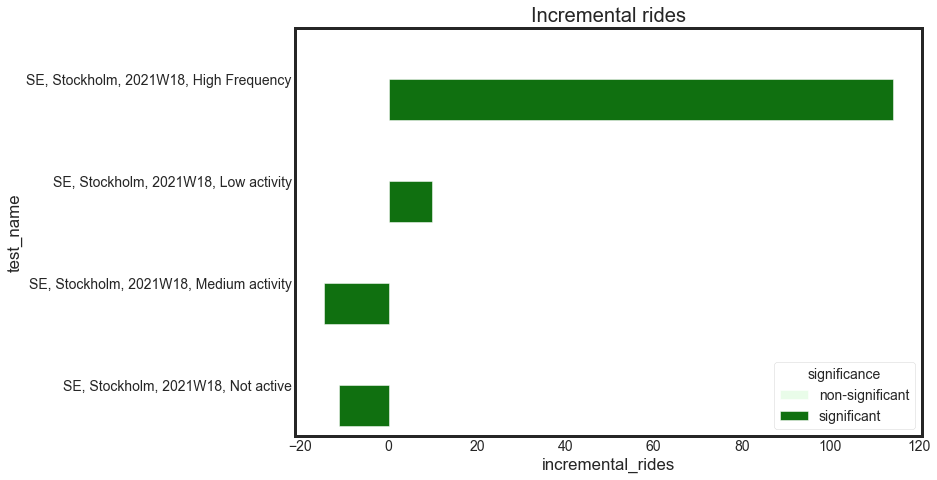

In [37]:
import seaborn as sns
rentals_df['significance'] = np.where(rentals_df['finished_order_count p-val'] <= 0.05, "significant", 'non-significant' )
plt.figure(figsize=(10,7))
sns.set_style("white")
sns.barplot(y = 'test_name', x = 'incremental_rides', hue = 'significance', color = 'green', data = rentals_df, orient = "h")
plt.title('Incremental rides')
plt.show